In [1]:
using Pkg; Pkg.activate("."); Pkg.instantiate()
using LinearAlgebra
using PyPlot
using ControlSystems
using ForwardDiff

  Activating project at `~/OCRL/RL`


In [2]:
#Model parameters
g = 9.81 #m/s^2
m = 1.0 #kg 
ℓ = 0.3 #meters

h = 0.2 #time step (5 Hz)

0.2

In [3]:
#Planar Quadrotor Dynamics
function quad_dynamics(x,u)
    θ = x[3]
    
    ẍ = (1/m)*(u[1] + u[2])*sin(θ)
    ÿ = (1/m)*(u[1] + u[2])*cos(θ) - g
    θ̈ = (1/(0.2*m*ℓ*ℓ))*(ℓ/2)*(u[2] - u[1])
    
    return [x[4:6]; ẍ; ÿ; θ̈]
end

quad_dynamics (generic function with 1 method)

In [4]:
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

quad_dynamics_rk4 (generic function with 1 method)

In [5]:
#Linearized dynamics for hovering
x_hover = zeros(6)
u_hover = [0.5*m*g; 0.5*m*g]
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,u_hover),x_hover);
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(x_hover,u),u_hover);

In [6]:
n = 6     # number of state
m = 2     # number of controls
Tfinal = 10.0 # final time
N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

In [7]:
#2D Quadrotor Problem
x0 = [1.0; -0.5; 0; 0; 0; 0]

#LQR Cost Matrices
Q = Array(1.0*I(n))
R = Array(0.1*I(m))
#Qf = Array(1.0*I(2));
Qf = dare(A,B,Q,R); #This makes sure that the infinite-horizon K is the solution to the finite-horizon problem

In [8]:
function cost(x0, K)
    xtraj = zeros(n, N)
    utraj = zeros(m, N-1)
    vtraj = zeros(m, N-1)
    rollout!(xtraj,utraj,vtraj,x0,K,zeros(m,m),zeros(n,n))
    J = cost(xtraj,utraj,Q,R,Qf)
    return J
end
function cost(xtraj,utraj,Q,R,Qf)
    J = 0.0
    for k = 1:(N-1)
        j = 0.5*xtraj[:,k]'*Q*xtraj[:,k] + 0.5*utraj[:,k]'*R*utraj[:,k]
        J += j
    end
    j = 0.5*xtraj[:,N]'*Qf*xtraj[:,N]
    J += j
    return J
end

function cost_to_go(xtraj,utraj,Q,R,Qf)
    costvec = zeros(N)
    for k = 1:(N-1)
        j = 0.5*xtraj[:,k]'*Q*xtraj[:,k] + 0.5*utraj[:,k]'*R*utraj[:,k]
        costvec[k] = j
    end
    j = 0.5*xtraj[:,N]'*Qf*xtraj[:,N]
    costvec[N] = j
    cost_to_go = zeros(N)
    for k = 1:N
        cost_to_go[k] = sum(costvec[k:end])
    end
    return cost_to_go
end

cost_to_go (generic function with 1 method)

In [9]:
#Groud Truth Solution (Infinite-Horizon LQR Gain)
K_true = dlqr(A,B,Q,R)

2×6 Matrix{Float64}:
 -0.173043  1.32479  -1.5023  -0.287999  1.75495  -0.430164
  0.173043  1.32479   1.5023   0.287999  1.75495   0.430164

In [10]:
#Ground-truth Closed-loop simulation with LQR controller

function rollout!(xtraj,utraj,vtraj,x0,K,V,W)
    xtraj[:,1] .= x0
    for k = 1:(N-1)
        vtraj[:,k] .= sqrt(V)*randn(m)
        utraj[:,k] .= -K*xtraj[:,k] + vtraj[:,k]
        xtraj[:,k+1] .= A*xtraj[:,k] + B*utraj[:,k] + sqrt(W)*randn(n)
    end
end
    
xtraj_true = zeros(n,N)
utraj_true = zeros(m,N-1)
vtraj_true = zeros(m,N-1)

rollout!(xtraj_true,utraj_true,vtraj_true,x0,K_true,zeros(m,m),zeros(n,n))

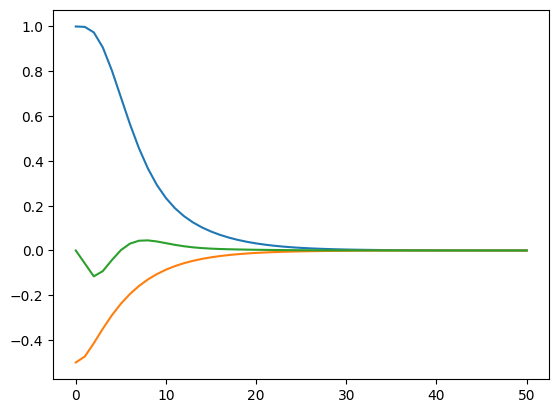

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7faa5808e0b8>

In [11]:
plot(xtraj_true[1,:])
plot(xtraj_true[2,:])
plot(xtraj_true[3,:])

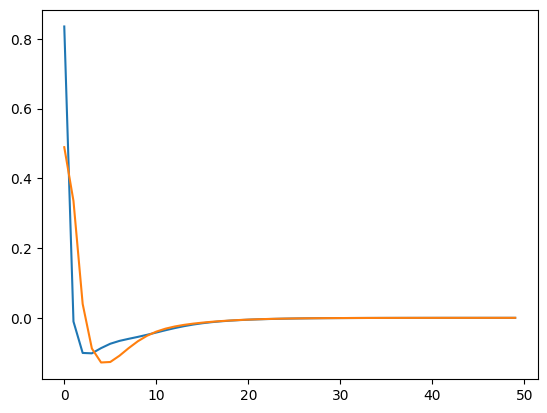

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7faa521ffbe0>

In [12]:
plot(utraj_true[1,:])
plot(utraj_true[2,:])

In [17]:
#Policy-Gradient Algorithm
iter = 1000 #number of outer-loop iterations
batch_size = 100 #number of rollouts per minibatch to estimate policy gradient

α0 = 0.01#1e-3 #step size ("learning rate")
β1 = 0.9
β2 = 0.999
ϵ = 1e-8

V = 0.001*I(m) #noise covariance for policy ("exploration")
W = zeros(n,n) #noise covariance for dynamics (process noise)

K0 = zeros(m,n)
K = deepcopy(K0)
baseline = 0.0
iter_costs = zeros(iter)
batch_costs = zeros(N,batch_size)
batch_vxt = zeros(N-1, m, n, batch_size)

adam_m = zeros(m,n)
adam_v = zeros(m,n)

xtraj_pg = zeros(n,N)
utraj_pg = zeros(m,N-1)
vtraj_pg = zeros(m,N-1);

In [14]:
#ADAM
for k = 1:iter
    
    #Do a bunch of rollouts with stochastic policy
    for j = 1:batch_size
        rollout!(xtraj_pg,utraj_pg,vtraj_pg,x0,K,V,W)
        batch_costs[:,j] .= cost_to_go(xtraj_pg,utraj_pg,Q,R,Qf)
        batch_vxt[:,:,:,j] .= reshape(vtraj_pg, N-1, m, 1).*reshape(xtraj_pg[:,1:N-1]', N-1, 1, n)
    end
    
    #Evaluate policy gradient from batch
    grad = zeros(m,n)
    baseline = (1.0/batch_size)*sum(batch_costs[1,:]) #use average cost as baseline
    for j = 1:batch_size
        grad -= sum(reshape(((batch_costs[1:N-1,j] .- baseline)./batch_size), N-1, 1, 1).*batch_vxt[:,:,:,j], dims=1)[1, :, :]
    end
    
    #Take ADAM step
    adam_m = β1*adam_m + (1-β1)*grad
    adam_v = β2*adam_v + (1-β2)*(grad.*grad)
    α = α0*sqrt(1-β2^(k+1))/(1-β1^(k+1))
    K -= α*adam_m./(sqrt.(adam_v).+ϵ)

    
    #Evaluate cost for plotting
    rollout!(xtraj_pg,utraj_pg,vtraj_pg,x0,K,zeros(m,m),zeros(n,n))
    iter_costs[k] = cost(xtraj_pg,utraj_pg,Q,R,Qf)
end

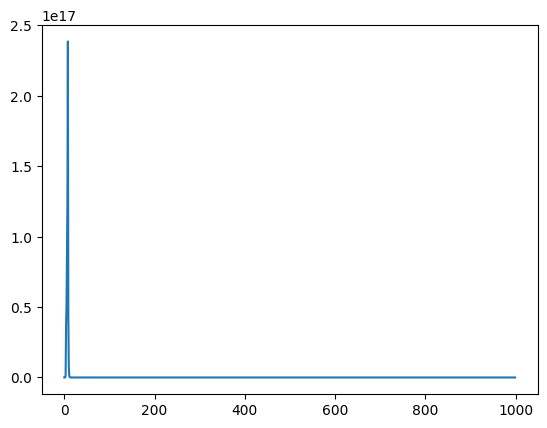

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7faa5216bba8>

In [15]:
plot(iter_costs)

In [103]:
#ADAM with line search
for k = 1:iter
    
    #Do a bunch of rollouts with stochastic policy
    for j = 1:batch_size
        rollout!(xtraj_pg,utraj_pg,vtraj_pg,x0,K,V,W)
        batch_costs[:,j] .= cost_to_go(xtraj_pg,utraj_pg,Q,R,Qf)
        batch_vxt[:,:,:,j] .= reshape(vtraj_pg, N-1, m, 1).*reshape(xtraj_pg[:,1:N-1]', N-1, 1, n)
    end
    
    #Evaluate policy gradient from batch
    grad = zeros(m,n)
    baseline = (1.0/batch_size)*sum(batch_costs[1,:]) #use average cost as baseline
    for j = 1:batch_size
        grad -= sum(reshape(((batch_costs[1:N-1,j] .- baseline)./batch_size), N-1, 1, 1).*batch_vxt[:,:,:,j], dims=1)[1, :, :]
    end
    
    #Take ADAM step
    adam_m = β1*adam_m + (1-β1)*grad
    adam_v = β2*adam_v + (1-β2)*(grad.*grad)
    
    c_old = cost(x0,K)
    c_new = c_old + 10000
    K_new = deepcopy(K)
    α = 10.0
    while isnan(c_new) || c_new > c_old
        K_new = K - α*adam_m./(sqrt.(adam_v).+ϵ)
        c_new = cost(x0,K_new)
        if α < 0.0000001
            break
        end
        α = 0.5*α
    end
    if α > 0.0000001
        K = K_new
    end

    
    #Evaluate cost for plotting
    rollout!(xtraj_pg,utraj_pg,vtraj_pg,x0,K,zeros(m,m),zeros(n,n))
    iter_costs[k] = cost(xtraj_pg,utraj_pg,Q,R,Qf)
end

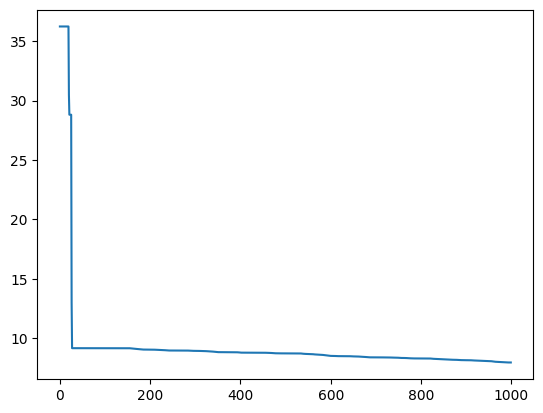

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe1b5a3b320>

In [104]:
plot(iter_costs)

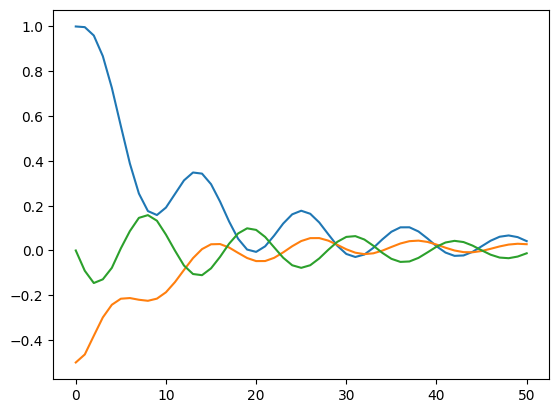

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe1b5a23208>

In [105]:
plot(xtraj_pg[1,:])
plot(xtraj_pg[2,:])
plot(xtraj_pg[3,:])

In [109]:
iter_costs[end]

7.968849702394411

In [90]:
true_cost = cost(xtraj_true,utraj_true,Q,R,Qf)

4.988734311751817

In [106]:
K_true

2×6 Matrix{Float64}:
 -0.173043  1.32479  -1.5023  -0.287999  1.75495  -0.430164
  0.173043  1.32479   1.5023   0.287999  1.75495   0.430164

In [107]:
K

2×6 Matrix{Float64}:
 -0.633506  1.06411   -1.27243   -1.02396   1.72148  -0.459599
 -0.270524  0.702524   0.125153  -0.167814  1.54813   0.698938

In [108]:
norm.(eigvals(A-B*K))

6-element Vector{Float64}:
 0.8534805318507609
 0.4373672885555224
 0.964812992085612
 0.964812992085612
 0.8647661705230681
 0.9594047915877671